In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import statistics as s
from itertools import product
import csv
from math import floor

In [2]:
def FCA(G, s, k, iteration):
    """Implements the Firefly Cellular Automata model

    Args:
        G (NetworkX Graph): Input graph to the model
        s (array): Current state
        k (int): k-color FCA
        iteration (int): number of iterations

    Returns:
        ret: states at each iteration
        synchronize: whether the system synchronizes at the final iteration
    """
    b = (k-1)//2 # Blinking color
    ret = s
    s_next = np.zeros(G.number_of_nodes())
    for h in range(iteration):
        if h != 0:
            s = s_next # Update to the newest state
            ret = np.vstack((ret, s_next))
        s_next = np.zeros(G.number_of_nodes())
        for i in range(G.number_of_nodes()):
            flag = False # True if inhibited by the blinking neighbor
            if s[i] > b:
                for j in range(G.number_of_nodes()):
                    if s[j] == b and list(G.nodes)[j] in list(G.adj[list(G.nodes)[i]]):
                        flag = True
                if flag:
                    s_next[i] = s[i]
                else:
                    s_next[i] = (s[i]+1)%k
            else:
                s_next[i] = (s[i]+1)%k
    
    synchronize = False
    if len(np.unique(ret[-1])) == 1 and iteration != 1:
        synchronize = True
        
    return ret, synchronize

In [34]:
#generate all possible different connected networks with n nodes
#https://matplotlib.org/matplotblog/posts/draw-all-graphs-of-n-nodes/
def make_graphs(n=2, i=None, j=None):
    """Make a graph recursively, by either including, or skipping each edge.

    Edges are given in lexicographical order by construction."""
    out = []
    if i is None: # First call

        out  = [[(0,1)]+r for r in make_graphs(n=n, i=0, j=1)]
    elif j<n-1:
        out += [[(i,j+1)]+r for r in make_graphs(n=n, i=i, j=j+1)]
        out += [          r for r in make_graphs(n=n, i=i, j=j+1)]
    elif i<n-1:
        out = make_graphs(n=n, i=i+1, j=i+1)
    else:
        out = [[]]
    return out

def perm(n, s=None):
    """All permutations of n elements."""
    if s is None: return perm(n, tuple(range(n)))
    if not s: return [[]]
    return [[i]+p for i in s for p in perm(n, tuple([k for k in s if k!=i]))]

def permute(g, n):
    """Create a set of all possible isomorphic codes for a graph,

    as nice hashable tuples. All edges are i<j, and sorted lexicographically."""
    ps = perm(n)
    out = set([])
    for p in ps:
        out.add(tuple(sorted([(p[i],p[j]) if p[i]<p[j]
                              else (p[j],p[i]) for i,j in g])))
    return list(out)

def connected(g):
    """Check if the graph is fully connected, with Union-Find."""
    nodes = set([i for e in g for i in e])
    roots = {node: node for node in nodes}

    def _root(node, depth=0):
        if node==roots[node]: return (node, depth)
        else: return _root(roots[node], depth+1)

    for i,j in g:
        ri,di = _root(i)
        rj,dj = _root(j)
        if ri==rj: continue
        if di<=dj: roots[ri] = rj
        else:      roots[rj] = ri
    return len(set([_root(node)[0] for node in nodes]))==1

def filter(gs, target_nv):
    """Filter all improper graphs: those with not enough nodes,

    those not fully connected, and those isomorphic to previously considered."""
    mem = set({})
    gs2 = []
    for g in gs:
        nv = len(set([i for e in g for i in e]))
        if nv != target_nv:
            continue
        if not connected(g):
            continue
        if tuple(g) not in mem:
            gs2.append(g)
            mem |= set(permute(g, target_nv))
    return gs2

In [ ]:
#compute width to check the half-circle concentration
#from L2PSync repo
def width_compute(coloring, kappa):
    differences = [np.max(coloring) - np.min(coloring)]
    for j in range(1,kappa+1):
        shifted = (np.array(coloring) + j) % kappa
        differences.append(np.max(shifted) - np.min(shifted))
    return np.min(differences)

In [35]:
num_nodes = 6
kappa = 4
color_list = list(product(range(0, kappa), repeat=num_nodes)) #generate all possible combination of color lists
len(color_list)

4096

In [36]:
gs = make_graphs(num_nodes)
gs = filter(gs, num_nodes) #list of all possible different networks with n nodes
len(gs)

112

In [40]:
#generate the toy dataset
file = open('toy.csv', 'w+', newline ='')

FCA_iter = 30
with file:   
    write = csv.writer(file)
    for col in color_list:
        for i in gs:
            G = nx.Graph()
            G.add_edges_from(i)

            num_edges = G.number_of_edges()
            #num_nodes = G.number_of_nodes()
            min_degree = min(list(G.degree), key=lambda x:x[1])[1]
            max_degree = max(list(G.degree), key=lambda x:x[1])[1]
            diameter = nx.diameter(G)
            quartile_1 = s.quantiles(col, n=4)[0]
            quartile_2 = s.quantiles(col, n=4)[1]
            quartile_3 = s.quantiles(col, n=4)[2]

            sample = [num_edges, num_nodes, min_degree, max_degree, diameter, 
                       quartile_1, quartile_2, quartile_3]
            states, label = FCA(G, col, kappa, FCA_iter)
            sample.append(label)
            for j in range(5):
                sample = sample+list(states[j])
            
            width = width_compute(states[FCA_iter-1],kappa)
            concentration = False
            if(width < floor(kappa/2)): #half circle concentration
                concentration = True
            sample.append(concentration)
            write.writerow(sample)

In [74]:
df=pd.read_csv("toy_6node_4kappa_30iter.csv")

In [75]:
Y_data = df.iloc[:, 39] #concentration
df.drop(df.columns[8], axis=1, inplace=True) #remove synchronization column
df.drop(df.columns[38], axis=1, inplace=True) #remove synchronization column

In [76]:
Y_data
df

,num_edges,num_nodes,min_degree,max_degree,diameter,quartile_1,quartile_2,quartile_3,s1_1,s1_2,...,s4_3,s4_4,s4_5,s4_6,s5_1,s5_2,s5_3,s5_4,s5_5,s5_6
0,15,6,5,5,1,0.0,0.0,0.0,0,0,...,3,3,3,3,0,0,0,0,0,0
1,14,6,4,5,2,0.0,0.0,0.0,0,0,...,3,3,3,3,0,0,0,0,0,0
2,13,6,3,5,2,0.0,0.0,0.0,0,0,...,3,3,3,3,0,0,0,0,0,0
3,12,6,3,5,2,0.0,0.0,0.0,0,0,...,3,3,3,3,0,0,0,0,0,0
4,12,6,2,5,2,0.0,0.0,0.0,0,0,...,3,3,3,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458747,6,6,1,3,3,3.0,3.0,3.0,3,3,...,2,2,2,2,3,3,3,3,3,3
458748,5,6,1,3,4,3.0,3.0,3.0,3,3,...,2,2,2,2,3,3,3,3,3,3
458749,5,6,1,3,4,3.0,3.0,3.0,3,3,...,2,2,2,2,3,3,3,3,3,3
458750,6,6,2,2,3,3.0,3.0,3.0,3,3,...,2,2,2,2,3,3,3,3,3,3


In [86]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)
sum(y_res==False)
X_train

,num_edges,num_nodes,min_degree,max_degree,diameter,quartile_1,quartile_2,quartile_3,s1_1,s1_2,...,s4_3,s4_4,s4_5,s4_6,s5_1,s5_2,s5_3,s5_4,s5_5,s5_6
3650,8,6,2,5,2,0.00,0.5,2.25,0,2,...,2,3,3,3,3,0,3,0,0,0
614,8,6,2,3,2,1.75,2.5,3.00,1,2,...,3,1,2,2,1,1,0,2,3,2
4343,5,6,1,3,4,0.00,1.5,2.00,0,0,...,3,0,0,1,0,0,0,1,1,2
3827,7,6,1,3,4,0.00,1.0,2.00,0,1,...,3,3,0,0,0,0,0,0,1,1
4621,8,6,2,4,2,0.75,1.5,2.25,1,0,...,0,3,0,3,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4054,14,6,4,5,2,0.75,1.5,3.00,1,3,...,3,0,3,3,0,1,0,1,0,0
1365,6,6,2,2,3,0.75,2.0,3.00,2,2,...,3,2,2,2,1,2,0,2,3,3
3903,10,6,2,4,2,1.00,2.0,2.25,2,3,...,0,0,0,0,1,2,1,1,1,1
4176,10,6,2,4,2,1.50,2.5,3.00,3,2,...,2,2,2,0,3,0,3,3,3,1


In [79]:
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
svc = SVC(kernel='linear', C=10.0, random_state=1)
svc.fit(X_train, y_train)
#
# Get the predictions
#
y_pred = svc.predict(X_test)
print(y_pred)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

[ True  True  True ... False  True  True]


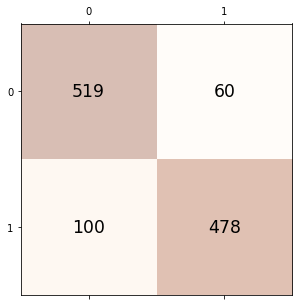

In [80]:
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

In [81]:
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Precision: 0.888
Recall: 0.827
F1: 0.857
Accuracy: 0.862


In [82]:
X_data = df.iloc[:, 8:38]
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_data, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)
sum(y_res==False)

2892

In [83]:
X_data

,s1_1,s1_2,s1_3,s1_4,s1_5,s1_6,s2_1,s2_2,s2_3,s2_4,...,s4_3,s4_4,s4_5,s4_6,s5_1,s5_2,s5_3,s5_4,s5_5,s5_6
0,0,0,0,0,0,0,1,1,1,1,...,3,3,3,3,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,1,1,...,3,3,3,3,0,0,0,0,0,0
2,0,0,0,0,0,0,1,1,1,1,...,3,3,3,3,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,1,1,...,3,3,3,3,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,1,1,...,3,3,3,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458747,3,3,3,3,3,3,0,0,0,0,...,2,2,2,2,3,3,3,3,3,3
458748,3,3,3,3,3,3,0,0,0,0,...,2,2,2,2,3,3,3,3,3,3
458749,3,3,3,3,3,3,0,0,0,0,...,2,2,2,2,3,3,3,3,3,3
458750,3,3,3,3,3,3,0,0,0,0,...,2,2,2,2,3,3,3,3,3,3


In [84]:
svc = SVC(kernel='linear', C=10.0, random_state=1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_matrix

array([[526,  53],
       [253, 325]])

In [85]:
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Precision: 0.860
Recall: 0.562
F1: 0.680
Accuracy: 0.736
